## Imports

In [8]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision.io import read_image, ImageReadMode
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import time
import os

from tempfile import TemporaryDirectory

from utils import natural_sort_key

In [19]:
# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [2]:
DATA_PATH = os.path.join(os.getcwd(), "data")

TASK1_PATH = os.path.join(DATA_PATH, "task1")
TRAIN_TASK1 = os.path.join(TASK1_PATH, "train_data", "annotations.csv")
TRAIN_TASK1_UNLABELED = os.path.join(TASK1_PATH, "train_data", "images", "unlabeled")

VAL_TASK1 = os.path.join(TASK1_PATH, "val_data")

TASK2_PATH = os.path.join(DATA_PATH, "task2")
TRAIN_TASK2 = os.path.join(TASK2_PATH, "train_data", "annotations.csv")
VAL_TASK2 = os.path.join(TASK2_PATH, "val_data")

## Load data

In [49]:
class LabeledData(Dataset):
    def __init__(self, annotation_file, transform=None) -> None:
        self._annotations = pd.read_csv(annotation_file)
        self.labels = self._annotations["label"]
        self.images_path = self._annotations["sample"]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(DATA_PATH, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")
        label = self.labels[idx].item()

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)


class UnlabeledData(Dataset):
    def __init__(self, image_dir, transform=None) -> None:
        self.image_dir = image_dir
        self.images_path = sorted(os.listdir(image_dir), key=natural_sort_key)
        self.labels = [None for x in range(len(self.images_path))]
        self.transform = transform

    def __getitem__(self, idx):
        _path_to_image = os.path.join(self.image_dir, self.images_path[idx])
        image = Image.open(_path_to_image).convert("RGB")

        try:
            label = self.labels[idx].item()

        except:
            label = 1000

        if self.transform:
            image = self.transform(image)

        return image, label, _path_to_image

    def __len__(self):
        return len(self.images_path)


class CombinedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None) -> None:
        self.images_path = image_paths
        self.labels = labels

        print(self.images_path)

        print(self.labels)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.images_path.loc[idx]).convert("RGB")

        try:
            label = self.labels[idx].item()

        except:
            label = 1000

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images_path)

In [4]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        normalize,
    ]
)

In [5]:
dataset = LabeledData(TRAIN_TASK1,transform=transform)

In [10]:
dataset_unlabeled = UnlabeledData(TRAIN_TASK1_UNLABELED,transform=transform)

In [11]:
len(dataset_unlabeled.images_path)

26445

In [12]:
def get_split_dataset(
    data,
    seed=42,
    test_size=0.2,
    batch_size = 64
):
    """Taken form https://stackoverflow.com/a/68338670"""
   
    # generate indices: instead of the actual data we pass in integers instead
    train_indices, test_indices, _, _ = train_test_split(
        range(len(data)),
        data.labels,
        stratify=data.labels,
        test_size=test_size,
        random_state=seed,
    )

    # generate subset based on indices
    train_split = Subset(data, train_indices)
    test_split = Subset(data, test_indices)

    # create batches
    train_batches = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    test_batches = DataLoader(test_split, batch_size=batch_size)


    return train_batches, test_batches

In [13]:
train_loader, valid_loader = get_split_dataset(dataset, batch_size=64)

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

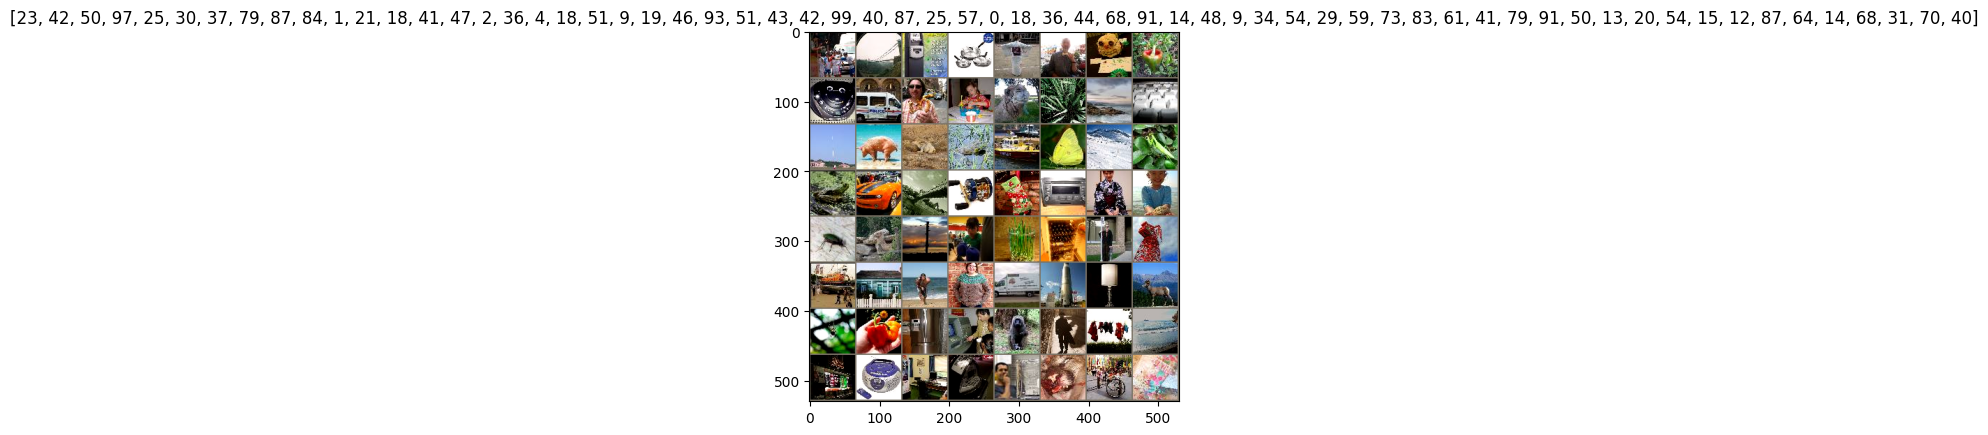

In [16]:
def test_loader(dataloader, is_labeled=True):
    # Get a batch of training data

    if is_labeled:
        inputs, classes = next(iter(dataloader))
    else:
        inputs, classes, _ = next(iter(dataloader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[x.item() for x in classes])


test_loader(train_loader)

## Base model resnet50

In [17]:
def train_model(model, criterion, optimizer, scheduler,train_loader,valid_loader, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Training phase

            model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            scheduler.step()

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = running_corrects.float() / len(train_loader)

            print(f"Train\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            print()

            model.eval()

            running_loss = 0.0
            running_corrects = 0
            # Validation phase
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(valid_loader)
            epoch_acc = running_corrects.float() / len(valid_loader)

            print(f"Valid\n\t Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model

In [20]:
model_teacher = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_teacher.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_teacher.fc = nn.Linear(num_ftrs, 100)

model_teacher = model_teacher.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_teacher.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_teacher = train_model(
    model_teacher,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_loader,
    valid_loader,
    num_epochs=8,
)

Epoch 0/7
----------
Train
	 Loss: 195.6861 Acc: 23.3153

Valid
	 Loss: 102.9639 Acc: 39.0946
Epoch 1/7
----------
Train
	 Loss: 84.9283 Acc: 42.5593

Valid
	 Loss: 76.8481 Acc: 43.3919
Epoch 2/7
----------
Train
	 Loss: 57.9730 Acc: 48.7288

Valid
	 Loss: 70.9462 Acc: 44.9595
Epoch 3/7
----------
Train
	 Loss: 41.5949 Acc: 52.9153

Valid
	 Loss: 69.0662 Acc: 45.7838
Epoch 4/7
----------
Train
	 Loss: 29.7430 Acc: 56.2034

Valid
	 Loss: 69.7521 Acc: 45.7297
Epoch 5/7
----------
Train
	 Loss: 22.1737 Acc: 58.3254

Valid
	 Loss: 69.9504 Acc: 45.8514
Epoch 6/7
----------
Train
	 Loss: 15.9682 Acc: 60.0542

Valid
	 Loss: 71.0659 Acc: 45.7162
Epoch 7/7
----------
Train
	 Loss: 11.6216 Acc: 61.4271

Valid
	 Loss: 70.7056 Acc: 46.0405
Training complete in 13m 27s
Best val Acc: 46.040539


In [22]:
import re
from tqdm import tqdm
from pathlib import Path


def predict(model, transform, img_path, base_dir=""):
    img = Image.open(os.path.join(base_dir, img_path)).convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return preds[0].item()


def write_submission(data: pd.DataFrame, task_name: str = None, filename: str = None):
    submission_dir = os.path.join(DATA_PATH, "submission", task_name)

    if task_name not in ["task1", "task2"]:
        raise TypeError(
            "Task name is mandatory and can have the value: Task1 or Task2."
        )

    if not Path(submission_dir).exists():
        os.makedirs(submission_dir)

    if filename is None:
        filename = "submission"
       

    _filename = os.path.join(
        DATA_PATH, submission_dir, filename + ".csv"
    )

    index = 1
    while os.path.exists(_filename):
        _filename = os.path.join(
            DATA_PATH, submission_dir, filename + "_" + str(index) + ".csv"
        )
        index = index + 1

    data.to_csv(_filename, index=False)


def create_data(dictionary: dict):
    df = pd.DataFrame.from_dict(dictionary, orient="index")
    df.reset_index(inplace=True)
    df.columns = ["sample", "label"]

    return df


def create_submission(
    model, transform=None, task_name: str = None, valid_dir: str = None
):
    if valid_dir is None:
        raise TypeError("The path must be str")

    image_paths = sorted(os.listdir(valid_dir), key=natural_sort_key)

    valid_dict = {}
    for img_path in tqdm(image_paths, desc="Predict images"):
        valid_dict[img_path] = predict(model, transform, img_path, valid_dir)

    data = create_data(valid_dict)

    write_submission(data, task_name)

In [23]:
create_submission(model_teacher, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:29<00:00, 55.65it/s]


### Task2

In [16]:
dataset_task2 = LabeledData(TRAIN_TASK2, transform=transform)

In [17]:
dataset_task2.labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [18]:
train_loader_task2, valid_loader_task2 = get_split_dataset(dataset_task2, batch_size=64)

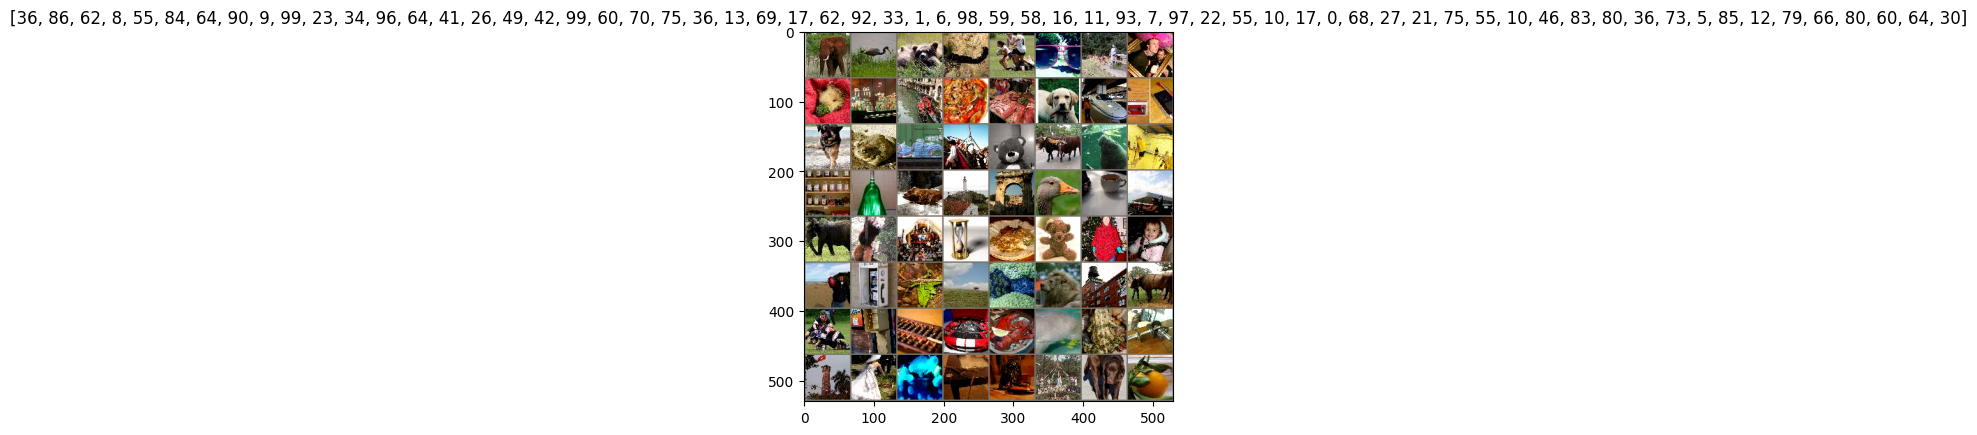

In [19]:
# Get a batch of training data
inputs, classes = next(iter(train_loader_task2))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x.item() for x in classes])

In [20]:
model_task2 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_task2.fc = nn.Linear(num_ftrs, 100)

model_task2 = model_task2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_task2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_task2 = train_model(
    model_task2, criterion, optimizer_ft, exp_lr_scheduler, train_loader_task2,valid_loader_task2,num_epochs=10
)

Epoch 0/9
----------
Train
	 Loss: 166.3826 Acc: 25.4256

Valid
	 Loss: 103.1278 Acc: 36.2102
Epoch 1/9
----------
Train
	 Loss: 92.1135 Acc: 37.8400

Valid
	 Loss: 91.7004 Acc: 37.7580
Epoch 2/9
----------
Train
	 Loss: 71.8360 Acc: 42.3344

Valid
	 Loss: 89.1167 Acc: 38.0955
Epoch 3/9
----------
Train
	 Loss: 57.7620 Acc: 45.9344

Valid
	 Loss: 89.0988 Acc: 37.9682
Epoch 4/9
----------
Train
	 Loss: 46.5798 Acc: 48.9728

Valid
	 Loss: 89.9065 Acc: 38.0892
Epoch 5/9
----------
Train
	 Loss: 37.3577 Acc: 51.8224

Valid
	 Loss: 92.6628 Acc: 37.7452
Epoch 6/9
----------
Train
	 Loss: 30.1634 Acc: 54.3184

Valid
	 Loss: 95.6747 Acc: 37.2229
Epoch 7/9
----------
Train
	 Loss: 22.9331 Acc: 57.1904

Valid
	 Loss: 94.8249 Acc: 37.6306
Epoch 8/9
----------
Train
	 Loss: 22.0988 Acc: 57.5648

Valid
	 Loss: 95.2804 Acc: 37.5287
Epoch 9/9
----------
Train
	 Loss: 21.1712 Acc: 57.8880

Valid
	 Loss: 95.1015 Acc: 37.8153
Training complete in 35m 17s
Best val Acc: 38.095543


In [22]:
create_submission(model_task2,transform,"task2",VAL_TASK2)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:27<00:00, 57.29it/s]


## Implement MPL 
Meta Pseudo Learning


In [26]:
import copy

In [27]:
teacher_model = copy.deepcopy(model_teacher)

CONFIDENCE = 0.80

# teacher_model.eval()

In [28]:
unlabeled_loader = DataLoader(dataset_unlabeled,batch_size=32,shuffle=True)


In [29]:
def generate_pseudo_labels(teacher_model, dataloader, confidences_threshold=0.8):
    # Store pseudo-labeled data
    pseudo_labeled_data = []

    teacher_model.eval()
    with torch.no_grad():
        for images, _, img_paths in tqdm(dataloader, desc="Generate PSEUDO-LABELS"):
            images = images.to(device)
            outputs = teacher_model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, pseudo_labels = torch.max(probabilities, dim=1)

            # Filter out low confidence predictions
            high_confidence_mask = confidences > confidences_threshold

            high_confidence_images = images[high_confidence_mask]
            high_confidence_labels = pseudo_labels[high_confidence_mask]
            high_confidence_paths = [
                img_paths[i] for i in range(len(img_paths)) if high_confidence_mask[i]
            ]

            for img, path, label in zip(
                high_confidence_images, high_confidence_paths, high_confidence_labels
            ):
                pseudo_labeled_data.append((img.cpu(), path, label.cpu()))

    pseudo_labels_dict = {
        "sample": [row[1] for row in pseudo_labeled_data],
        "label": [row[2].item() for row in pseudo_labeled_data],
    }

    df_pseudo = pd.DataFrame(pseudo_labels_dict)

    print(f"Generated new {len(df_pseudo)} pseudo labels")

    return df_pseudo

In [76]:
def create_combined_dataframe(data_path_1: str or Path, data_2: pd.DataFrame):
    df_labeled = pd.read_csv(data_path_1)

    print(type(df_labeled))

    df_labeled["sample"] = DATA_PATH + "/" + df_labeled["sample"]

    return pd.concat([df_labeled, data_2], ignore_index=True)

In [32]:
df_pseudo = generate_pseudo_labels(teacher_model, unlabeled_loader)

Generate PSEUDO-LABELS: 100%|██████████| 827/827 [00:50<00:00, 16.53it/s]

Generated new 16534 pseudo labels


In [77]:
combined_dataset = create_combined_dataframe(TRAIN_TASK1, df_pseudo)

<class 'pandas.core.frame.DataFrame'>


In [80]:
combined_set = CombinedDataset(
    combined_dataset["sample"].copy(), combined_dataset["label"].copy(), transform
)

0        /Users/marianluca/Documents/Master/ATAI/Homewo...
1        /Users/marianluca/Documents/Master/ATAI/Homewo...
2        /Users/marianluca/Documents/Master/ATAI/Homewo...
3        /Users/marianluca/Documents/Master/ATAI/Homewo...
4        /Users/marianluca/Documents/Master/ATAI/Homewo...
                               ...                        
40084    /Users/marianluca/Documents/Master/ATAI/Homewo...
40085    /Users/marianluca/Documents/Master/ATAI/Homewo...
40086    /Users/marianluca/Documents/Master/ATAI/Homewo...
40087    /Users/marianluca/Documents/Master/ATAI/Homewo...
40088    /Users/marianluca/Documents/Master/ATAI/Homewo...
Name: sample, Length: 40089, dtype: object
0         0
1         1
2         2
3         3
4         4
         ..
40084    50
40085    88
40086    55
40087    46
40088    85
Name: label, Length: 40089, dtype: int64


In [81]:
train_combined, test_combined = get_split_dataset(combined_set)

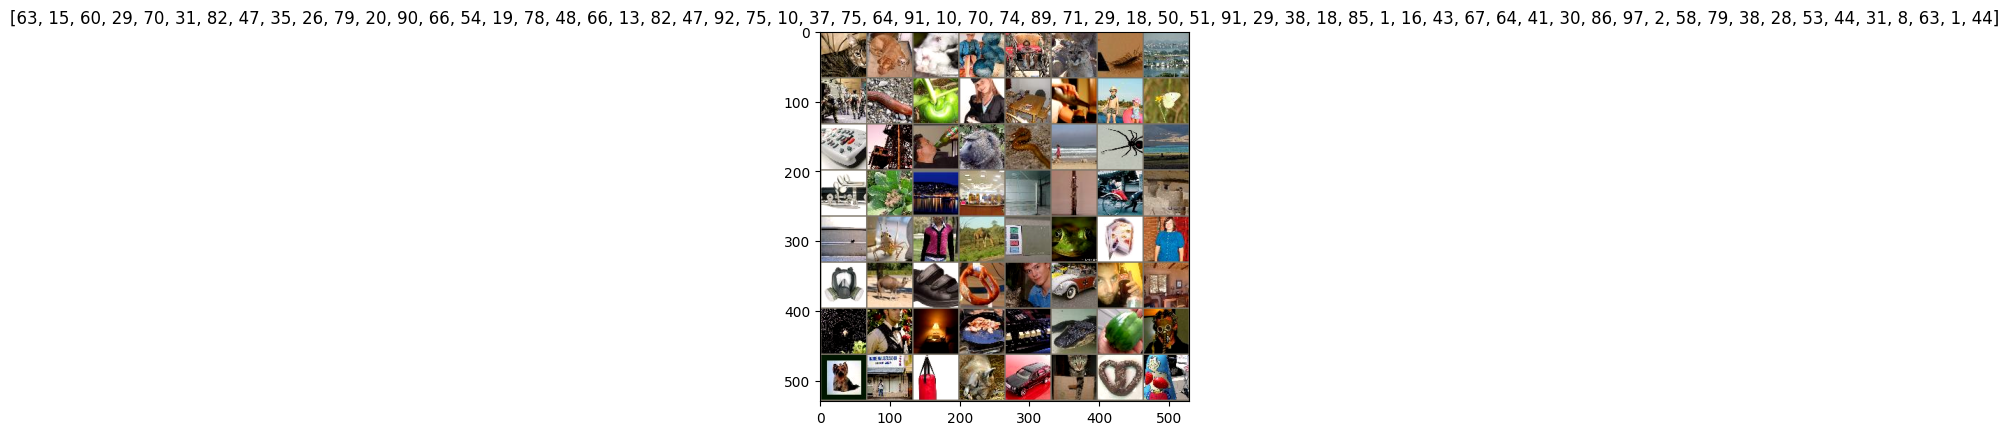

In [84]:
test_loader(train_combined)

In [85]:
student_model = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = student_model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
student_model.fc = nn.Linear(num_ftrs, 100)

student_model = student_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [86]:
stud = train_model(
    student_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    train_combined,
    test_combined,
    num_epochs=8,
)

Epoch 0/7
----------
Train
	 Loss: 136.1147 Acc: 35.4283

Valid
	 Loss: 57.2219 Acc: 49.4524
Epoch 1/7
----------
Train
	 Loss: 48.6227 Acc: 51.6036

Valid
	 Loss: 46.1460 Acc: 51.7063
Epoch 2/7
----------
Train
	 Loss: 31.6833 Acc: 55.6056

Valid
	 Loss: 44.1124 Acc: 52.3968
Epoch 3/7
----------
Train
	 Loss: 22.2286 Acc: 58.0239

Valid
	 Loss: 41.9007 Acc: 52.8254
Epoch 4/7
----------
Train
	 Loss: 15.4638 Acc: 60.0578

Valid
	 Loss: 42.2423 Acc: 53.0238
Epoch 5/7
----------
Train
	 Loss: 11.3930 Acc: 61.0319

Valid
	 Loss: 42.9054 Acc: 52.8810
Epoch 6/7
----------
Train
	 Loss: 8.3247 Acc: 61.9263

Valid
	 Loss: 43.6183 Acc: 53.0397
Epoch 7/7
----------
Train
	 Loss: 6.0641 Acc: 62.5498

Valid
	 Loss: 43.8548 Acc: 52.6746
Training complete in 31m 47s
Best val Acc: 53.039684


In [87]:
create_submission(student_model, transform, "task1", VAL_TASK1)

Predict images:   0%|          | 0/5000 [00:00<?, ?it/s]

Predict images: 100%|██████████| 5000/5000 [01:52<00:00, 44.52it/s]


In [ ]:
def train_mlp(teacher_model, student_model, criterion, optimizer, scheduler, train_loader, unlabeled_loader, valid_loader, num_epochs=25):
    
    for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # 1. Train Teacher Model on Labeled Data
            train_model(teacher_model, criterion, optimizer, scheduler, train_loader)

            # 2. Generate Pseudo Labels for Unlabeled Data
            pseudo_labels = generate_pseudo_labels(teacher_model, unlabeled_loader)

            # 3. Combine Pseudo Labels with Labeled Data
            combined_loader = combine_loaders(train_loader, pseudo_labels)

            # 4. Train Student Model on Combined Data
            train_model(student_model, criterion, optimizer, scheduler, combined_loader)

            # 5. Evaluate Student Model
            student_acc = evaluate_model(student_model, valid_loader)

            # 6. Update Teacher Model based on Student's Performance
            update_teacher_model(teacher_model, student_model, train_loader, student_acc)

            # 7. Save Best Student Model
            if student_acc > best_acc:
                best_acc = student_acc
                torch.save(student_model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {best_acc:4f}")

        # Load best student model weights
        student_model.load_state_dict(torch.load(best_model_params_path))

    return student_model